In [1]:
!pip -q install langchain_openai langchain_core langchain_tavily langchain_community tavily-python langgraph langgraph-prebuilt 
!pip -q install langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai notebook
!pip -q install tavily-python wikipedia trustcall langgraph-cli langchain_groq groq langgraph-checkpoint-sqlite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.1/467.1 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.4 MB/s eta 0:00:00


In [2]:
from IPython.display import Image
from IPython.display import Image, display
from IPython.display import Markdown
from dataclasses import dataclass
from kaggle_secrets import UserSecretsClient
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.messages import AnyMessage
from langchain_core.messages import HumanMessage
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.messages import RemoveMessage
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.messages import get_buffer_string
from langchain_core.messages import trim_messages
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.errors import InvalidUpdateError
from langgraph.graph import END
from langgraph.graph import END, StateGraph, START
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.graph import START, StateGraph
from langgraph.graph import StateGraph, START
from langgraph.graph import StateGraph, START, END
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.types import Send
from operator import add
from pprint import pprint
from pydantic import BaseModel
from pydantic import BaseModel, Field
from pydantic import BaseModel, ValidationError
from pydantic import BaseModel, field_validator, ValidationError
from typing import Annotated
from typing import Any
from typing import List
from typing import List, Annotated
from typing import List, Optional, Annotated
from typing import Literal
from typing_extensions import Literal
from typing_extensions import TypedDict
import json
import operator
import os
import random
import sqlite3

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
LANGSMITH_TRACING_V2=True
LANGSMITH_PROJECT="svg_langchain"
os.environ["LANGSMITH_API_KEY"] = user_secrets.get_secret("LANGSMITH_API_KEY")
os.environ["OPENAI_API_KEY"] = user_secrets.get_secret("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = user_secrets.get_secret("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = user_secrets.get_secret("TAVILY_API_KEY")
os.environ["HF_API_KEY"] = user_secrets.get_secret("HF_API_KEY")
os.environ["OPENROUTER_API_KEY"] = user_secrets.get_secret("OPENROUTER_API_KEY")

# NO cuDNN Logs 
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

'''
+-----------------------------------------------+---------------------+------------------+-------------------+----------------+---------+
|                     Model                     | Requests per Minute | Requests per Day | Tokens per Minute | Tokens per Day | Actions |
+-----------------------------------------------+---------------------+------------------+-------------------+----------------+---------+
| llama-3.1-8b-instant                          |                  30 |            14.4K |                6K |           500K |         |
| llama-3.3-70b-versatile                       |                  30 |               1K |               12K |           100K |         |
| meta-llama/llama-4-maverick-17b-128e-instruct |                  30 |               1K |                6K |           500K |         |
| meta-llama/llama-4-scout-17b-16e-instruct     |                  30 |               1K |               30K |           500K |         |
| meta-llama/llama-guard-4-12b                  |                  30 |            14.4K |               15K |           500K |         |
| moonshotai/kimi-k2-instruct                   |                  60 |               1K |               10K |           300K |         |
| moonshotai/kimi-k2-instruct-0905              |                  60 |               1K |               10K |           300K |         |
| openai/gpt-oss-120b                           |                  30 |               1K |                8K |           200K |         |
| openai/gpt-oss-20b                            |                  30 |               1K |                8K |           200K |         |
| qwen/qwen3-32b                                |                  60 |               1K |                6K |           500K |         |
+-----------------------------------------------+---------------------+------------------+-------------------+----------------+---------+
'''

2025-10-25 13:11:54.086731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761397914.301298      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761397914.363146      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'\n+-----------------------------------------------+---------------------+------------------+-------------------+----------------+---------+\n|                     Model                     | Requests per Minute | Requests per Day | Tokens per Minute | Tokens per Day | Actions |\n+-----------------------------------------------+---------------------+------------------+-------------------+----------------+---------+\n| llama-3.1-8b-instant                          |                  30 |            14.4K |                6K |           500K |         |\n| llama-3.3-70b-versatile                       |                  30 |               1K |               12K |           100K |         |\n| meta-llama/llama-4-maverick-17b-128e-instruct |                  30 |               1K |                6K |           500K |         |\n| meta-llama/llama-4-scout-17b-16e-instruct     |                  30 |               1K |               30K |           500K |         |\n| meta-llama/llama-guard

In [3]:
from langchain_groq import ChatGroq 
# llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
llm = ChatGroq(model="moonshotai/kimi-k2-instruct-0905", temperature=0) 
# llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0) 
# llm = ChatGroq(model="openai/gpt-oss-20b", temperature=0) 

model = llm

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
1Structure
State of the graph. State schema - schema for all Nodes & Edges in graph. State - текущее состояние графа, структура/хранилище для Всех данных
from typing_extensions import TypedDict
class State(TypedDict):
    graph_state: str

In [ ]:
Nodes. Nodes are python functions. Each node can access key (from state) and returns New value of state key. 
New value from new node Update previous value from old node (logic). Просто узел 
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}
def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}
def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

In [ ]:
Edges. Edges are connect nodes. Normal edges - from 1node to 2node. Conditional edges - you choose nodes that you need. Просто ребра 
import random
from typing import Literal
def ConditionalEdge(state) -> Literal["node_2", "node_3"]:
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:
        # 50% of the time, we return Node 2
        return "node_2"
    # 50% we return Node 3
    return "node_3"

In [ ]:
BuildGraph(), graph construction. START node need to define where to start graph, analogically END node. 
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", ConditionalEdge)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()
# View
# display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
Invoke(). invoke() used to execute components. {"graph_state" : "Hi, svg welcomes you."} - start(initial) value for graph. invoke() continues until he reaches END node.
graph.invoke({"graph_state" : "Hi, svg welcomes you."})
---Node 1---
---Node 3---
{'graph_state': 'Hi, svg welcomes you. I am sad!'}
It returns the final state of graph 

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
2Chain | Building chain using chat messages as graph state, chat models in nodes, binding tools to chat model, executing tool calls in nodes.

In [ ]:
Messages. Each message can be supplied/consist of content, name (message_author), response_metadata (in AImessage).
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

In [ ]:
Chat models.
import os
user_secrets = UserSecretsClient()
os.environ["GROQ_API_KEY"] = user_secrets.get_secret("GROQ_API_KEY")
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

In [ ]:
Tools. 
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b
llm_with_tools = llm.bind_tools([multiply])

In [ ]:
Messages as State.
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [ ]:
Reducers. We have problem with node - each node will return new value for our state And therefore override previous value. But we want to append,
not override, messages to our state - and reducers solve that. They allow to specify how state updates performed. Pre-built reducer 'add_messages'.
But 'LangGraph' also has 'MessagesState' for that.  
from typing import Annotated
from langgraph.graph.message import add_messages
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
#or 
from langgraph.graph import MessagesState
class MessagesState(MessagesState):
    pass

In [ ]:
MessagesState
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
3'Router'. It is example of simple agent, here LLM directing workflow.
Extend graph to - add node that call 'tool' if needed, add conditional edge that look on llm output and route to 'tool-calling' node or end node.

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b
llm_with_tools = llm.bind_tools([multiply])

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
4'ReAct', General Agent architecture.
act - let model call specific tools
observe - pass the tool output back to model
reason - let model reason about 'tool output' to decide what to do next 

In [17]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.
    Args:
        a: first int
        b: second int
    """
    return a + b
def divide(a: int, b: int) -> float:
    """Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a / b
def difference(a: int, b: int) -> int:
    """ Difference a and b.
    Args: 
        a: first int
        b: second int
    """
    return a - b
tools = [add, multiply, divide, difference]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [ ]:
After 'assistant node' executes, 'tools_condition' checks if model`s output is a tool call 
If it`s tool call - workflow directed to 'tools' node
`tools` node connects back to 'assistant' node 
This loop continues as long as model decides to call tools
And if model`s response Not a tool call - directing to END, and proccess is finished

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
5Agent Memory. 
Basic graph/agent has no memory for previous interactions. So we will use 'persistence'; to remember interruptions. 
LangGraph can use checkpointer to automatically save 'graph_state'; after each step. 
Easiest checkpointer to use - 'MemorySaver';.
'thread_id'; will store our collection of graph states. 

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print() #output 14 

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
1State-schema. 
Defining state schema using various types.

In [ ]:
'TypedDict'. This is class from python`s 'typing'; module.
Allows to specify 'keys'; and their corresponding values.

from typing_extensions import TypedDict
class TypedDictState(TypedDict):
    foo: str
    bar: str

For more concrete value we can use 'Literal';
from typing import Literal
class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]



We can use our defined state class in LG by passing it to 'StateGraph';

import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}
def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}
def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5: #like previous
        return "node_2"
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
# graph.invoke({"name":"Lance"})


In [ ]:
'Dataclass'. Also python`s class. Offers concise(лаконичный) syntax for create classes to store data.
from dataclasses import dataclass
@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

To access keys of 'dataclass'; we need modify subscripting used in 'node_1'.
In each node we still return dict to perform state updates.
It`s possible because LG stores each key of state objsect separately.
Object returned by node only needs to have keys.

Below 'dataclass' has key 'name' so we can update it by passing dict from our node, same as we did when 'TypedDict'.
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke(DataclassState(name="Lance",mood="sad"))


In [ ]:
'Pydantic'. Also class from python. 
This is data validation & settings management Library using python`s type annotations. Well-suited for LG.

from pydantic import BaseModel, field_validator, ValidationError
class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 
    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value
try:
    state = PydanticState(name="Lancey Foux", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke(PydanticState(name="Lance",mood="sad"))

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
2State-reducers. 

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
class State(TypedDict):
    foo: int
def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"foo" : 1}) #output 2

In [ ]:
Branching. 

class State(TypedDict):
    foo: int
def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}
def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}
def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}") # Error

In [ ]:
Above issue(error). 'node_1'; branches to 'node_2'; and 'node_3';. 2 & 3 have parallel execution, they run in the same step of graph And
they both want to override 'state'; within same step. Reducers solve this
Reducers specify how to perform updates. e.g. 'Annotated'; type to specify reducer function().
For instance, lets append value, that returned from each node, rather than override/overwrite them.

from operator import add
from typing import Annotated
class State(TypedDict):
    foo: Annotated[list[int], add]
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"foo" : [1]})

Now state_key 'foo'; list now. 

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}
def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}
def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"foo" : [1]}) # [1, 2, 3, 3]

If we 'None'; to 'foo'; will appear Error, cause operator trying to attempt concatenate 'NoneType'; to list

In [ ]:
And to adress cases like this we can create/build Custom Reducers.
Below we define custom reducer to combine lists where some|all inputs are 'None';

def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]
class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

With default reducer we will face Error
With custom we will get {'foo': [2]}

In [ ]:
Messages. 'add_messages' = 'MessageState'

from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc
# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

# Initial message(state)
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")]
# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages , new_message) #output - messages above appended 

In [ ]:
If we pass message with same ID as an existing one in 'messages'; list, it will be get overwritten

initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")]
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")
add_messages(initial_messages , new_message) #output Hello!... & whales

In [ ]:
'add_messages'; also enables message removal - 'RemoveMessage';.
from langchain_core.messages import RemoveMessage

messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages) #[RemoveMessage(content='', id='1'), RemoveMessage(content='', id='2')]

add_messages(messages , delete_messages) #output msgs id=3 & id=4

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
3Multiple schemas.

In [ ]:
Private State.
Useful for anything needed as part of the intermediate work logic of graph, and only.
Define 'PrivateState'; where 'node_2'; uses it as input, but writes out to 'OverallState';.

from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
class OverallState(TypedDict):
    foo: int
class PrivateState(TypedDict):
    baz: int
def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}
def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"foo" : 1}) #output 3

In [ ]:
input / output Schema. 
By default, 'StateGraph'; takes in single schema and all nodes are expected to communicate with that schema.
However, it`s possible to define explicit(явные) input and output schemas (for) graph.
Usually, here we define 'internal'; schema that contains all keys relevant to graph operations.
But, we use spicific input & output schemas to constrain. 
Let`s run graph with single schema

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str
def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}
def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)
graph = graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"question":"hi"}) #{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

In [ ]:
class InputState(TypedDict):
    question: str
class OutputState(TypedDict):
    answer: str
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str
def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}
def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)
graph = graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"question":"hi"}) #{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his is name is Lance'}

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
4Filtering and trimming messages.

In [ ]:
Messages as state.

from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print() #output ehm just conversation

In [ ]:
Removing for upgrade memory.
Long-running conversations result in high token usage and latency (it`s how fast model give message to your request) - (it`s bad overall) - because we pass growing list of messages to model.
And to adress that we can, firstly recall using 'RemoveMessages'; and 'add_messages'; reducer.

from langchain_core.messages import RemoveMessage
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}
def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print() #output will on msgs with id=3 and id=4 Because of filter, others deleted 

In [ ]:
Filtering messages. 
e.g. we can pass not all messages to model, because of filter.

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))
for m in messages:
    m.pretty_print() #output will be all but message about narwhals

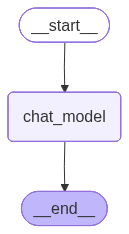

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [12]:
Trim messages.
This restricts message history to specified number of tokens. And to do this we use 'trim_messages';.

from langchain_openai import ChatOpenAI
from langchain_core.messages import trim_messages
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )
#[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]
#because all previous text was trimmed due to overlimit 100 tokens

# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages}) #output empty

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
5Chatbot with message summarization.
На русском легче объяснить и короче - Вместо того, чтобы просто бездумно обрезать или фильтровать сообщения мы будем сначала создавать summary всех эти 
сообщений чтобы потом грузануть это модели без фулл представления прошлого диалога, чтобы оставалось хотя бы что-то. Ну а после того как summary получили - 
удаляем всю прошлую историю. Такого рода trade-off между ничем и всем. А, и я так буквально всегда делаю при переносе чатов (long conversations своего рода).

As before we use 'MessagesState' and include custom key 'summary';.
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
# Define the logic to call the model
def call_model(state: State):
    # Get summary if it exists
    summary = state.get("summary", "")
    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"
        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]    
    else:
        messages = state["messages"]    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    # First, we get any existing summary
    summary = state.get("summary", "")
    # Create our summarization prompt 
    if summary:       
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )      
    else:
        summary_message = "Create a summary of the conversation above:"
    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    """Return the next node to execute."""
    messages = state["messages"]
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    # Otherwise we can just end
    return END

In [ ]:
Adding memory.
    
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
# Define a new graph
workflow = StateGraph(State) #or builder. 
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)
# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
Threads.
Checkpointer saves state at each step as checkpoint.
These saved checkpoints can be grouped into a 'thread'; of conversation. 
Slack - different channels carry different conversations.
Threads are like Slack channels, capturing grouped collections of state.
Below we use 'configurable'; to set thread ID.

# Create a thread
config = {"configurable": {"thread_id": "1"}}
# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    
graph.get_state(config).values.get("summary","")
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
graph.get_state(config).values.get("summary","")
#output 'Lance introduced himself and mentioned that he is a fan of the San Francisco 49ers...

================================== Ai Message ==================================

Hi Lance, it's nice to meet you. Is there something I can help you with or would you like to chat?
================================== Ai Message ==================================

I don't have any information about your name. I'm a large language model, I don't have the ability to retain information about individual users or their personal details. Each time you interact with me, it's a new conversation and I don't have any prior knowledge about you. If you'd like to share your name with me, I'd be happy to chat with you!
================================== Ai Message ==================================

The San Francisco 49ers are a legendary NFL team with a rich history of success. They've won five Super Bowl championships, including four in the 1980s with Hall of Famers like Joe Montana, Jerry Rice, and Ronnie Lott.

The 49ers have a passionate fan base, and their iconic red and gold colors are recogniz

ValueError: No checkpointer set

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
6Chatbot with external DB memory 
For create chatbot with indefinitely/infinite memory we need advanced checkpointers that support External DataBases, for example Sqlite or Postgres.

In [ ]:
Sqlite.

import sqlite3
# ":memory:" creates in-memory Sqlite db
conn = sqlite3.connect(":memory:", check_same_thread = False)

Random database
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

From previous topic 
# Define the logic to call the model
def call_model(state: State):
    # Get summary if it exists
    summary = state.get("summary", "")
    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"
        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]    
    else:
        messages = state["messages"]    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    # First, we get any existing summary
    summary = state.get("summary", "")
    # Create our summarization prompt 
    if summary:       
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )      
    else:
        summary_message = "Create a summary of the conversation above:"
    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    """Return the next node to execute."""
    messages = state["messages"]
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    # Otherwise we can just end
    return END

from IPython.display import Image, display
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)
graph = workflow.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}
# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()


Because we use database our state is saved/persisted, If we restart notebook we still can load from db on disk
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
UX & human-in-loop
human-in-loop use memory and allows users to interact directly with graphs.

In [ ]:
1Streaming.

LG built with first class support for streaming. Streaming is like invoke() but gives answer gradually, not immediately; And like word return but gradually.
'''here'''; code from previous-previous section  

In LG we have '.stream' & '.astream'. In them located modes: 'values'(mode) - returns full graph state when/after each node is called; 
'updates'(mode) - updates graph state when/after each node.
In updates each chunk is dict() with 'node_name' as key and with updated state as value.

config = {"configurable": {"thread_id": "1"}}
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

In [ ]:
We can do chat model calls using '.astream_events', which returns events as they happen inside nodes.
Each event is dict() and has - 'event'; type of event, 'name';, 'data';, 'metadata'; node that generate event.
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")
# Node: . Type: on_chain_start. Name: LangGraph
# Node: __start__. Type: on_chain_start. Name: __start__
# Node: __start__. Type: on_chain_end. Name: __start__
# Node: conversation. Type: on_chain_start. Name: conversation
# Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
# Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
# ...Previous string repeated many times...
# Node: conversation. Type: on_chat_model_end. Name: ChatOpenAI
# Node: conversation. Type: on_chain_start. Name: ChannelWrite<conversation,messages,summary>
# Node: conversation. Type: on_chain_end. Name: ChannelWrite<conversation,messages,summary>
# Node: conversation. Type: on_chain_start. Name: should_continue
# Node: conversation. Type: on_chain_end. Name: should_continue
# Node: conversation. Type: on_chain_stream. Name: conversation
# Node: conversation. Type: on_chain_end. Name: conversation
# Node: . Type: on_chain_stream. Name: LangGraph
# Node: . Type: on_chain_end. Name: LangGraph

We can use event['metadata']['langgraph_node'] to select node to stream from & use event['data'] to get actual data for each event (e.g. AIMessageChunk).
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])
# {'chunk': AIMessageChunk(content='', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
# {'chunk': AIMessageChunk(content='The', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
# {'chunk': AIMessageChunk(content=' San', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
# {'chunk': AIMessageChunk(content=' Francisco', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
# {'chunk': AIMessageChunk(content=' ', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
# {'chunk': AIMessageChunk(content='49', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
# ...and more...

config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")
Like how model separates to tokens 
# |The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.
# | They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| of| the| league|'s| National| Football| Conference|
# (|N|FC|)| West| division|.| Here| are| some| key| points| about| the| team|: ...........        

In [ ]:
2Breakpoints.
    
Human-in-loop important in LangGraph because of - 
1 Approval, we can interrupt(half stopped) our agent, message current state to user and allow user to accept action.
2 Debugging, reproduce or avoid issues by running back the graph.
3 Editing, we can modify state.
Breakpoints is simple/easy way to stop graph at some specific steps.    

In [ ]:
Breakpoints for human approval.

;'interrupt_before=["tools"]'; where tools is tools node - it means execution will be interrupted before node 'tools'; which executes tool call.
... graph = builder.compile(interrupt_before=["tools"], checkpointer=memory) 
state = graph.get_state(thread)
state.next #output ('tools',)
Just btw, when we invoke() graph witn 'None' it will continue from the last state checkpoint.

In [ ]:
3Editing graph_state.

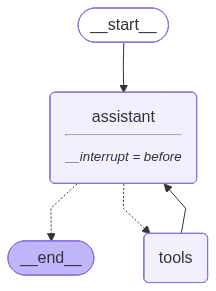

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!
================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (7gpxrsbn9)
 Call ID: 7gpxrsbn9
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9
================================= Tool Message =================================
Name: multiply

9
==================

In [12]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

state = graph.get_state(thread)
state

graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

In [ ]:
4Dynamic Breakpoints.
    
Breakpoints usually set by developer on specific node during graph compilation, but sometimes we can allow graph dynamically interrupt itself - it is internal breakpoint.
Internal breakpoint work by 'NodeInterrupt';.

    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")

In [ ]:
5Time travel.
Time travel is debugging by viewing, re-playing and forking from past states

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
1Parallelization.
It`s one of LangGraph controllability topics

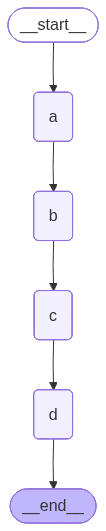

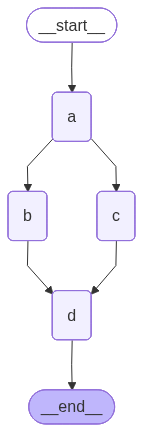

In [7]:
Distribution | Redistribution (распределение/перераспределение, fan out / fan in)

Base graph that over-writes state at each step.
class State(TypedDict):
    state: str
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile() 
graph.invoke({"state": []}) #{'state': ["I'm D"]}

Let`s run b & c in Parallel, and then run d. 
In other words, distribution from A to B & C and redistirbution to D.
And if we have really demand on that we need to use it with 'Reducer'` , so like that
from typing import Annotated
class State(TypedDict):
    state: Annotated[list, operator.add]
And instead of {'state': ["I'm D"]} will be {'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

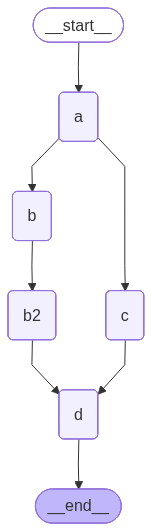

In [8]:
If we want where one parallel path has more than one steps.
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
-> {'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}


In [ ]:
On each step we don`t have specific/concrete control over order of state updates. Simply LangGraph controls it.
For control this we can use custom reducer.
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return sorted(left + right, reverse=False)
{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

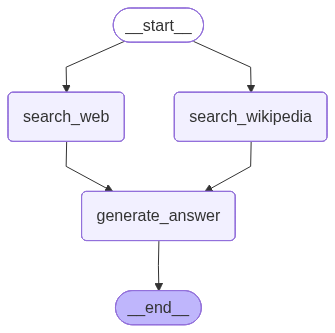

/tmp/ipykernel_37/4194739053.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


"Nvidia's Q2 2024 earnings were as follows:\n\n- Revenue: $30.0 billion, up 15% from the previous quarter and up 122% from a year ago.\n- GAAP earnings per diluted share: $0.67, up 12% from the previous quarter and up 168% from a year ago.\n- Non-GAAP earnings per diluted share: $0.68, up 11% from the previous quarter and up 152% from a year ago.\n- Data Center revenue: $26.3 billion, up 16% from Q1 and up 154% from a year ago.\n- Gaming division revenue: $2.49 billion, up 22% from a year earlier.\n- Adjusted gross margin: 71.2%, an increase of 25.3 percentage points due to growth in profit-rich data center sales."

In [14]:
Gather context from 2 external resources, Wikipedia & web-search, and have LLM to answer on question.

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    """ Retrieve docs from web search """
    
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    """ Retrieve docs from wikipedia """
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    """ Node to answer a question """
    context = state["context"]
    question = state["question"]
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)    
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    return {"answer": answer}
    
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]
builder = StateGraph(State)
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
2Sub-graphs.
(Like _graph1 -> _subgraph1 , _subgraph2 , _subgraph3 ...)

In [ ]:
Sub-graphs allows to create and manage different state in different parts of graph. 
Particularly/especially useful for Multi-Agent systems ('MAS'), when like we have team of agents and one agent have his own state. 

Simple example - we have system that accepts logs, it performs 2 separate sub-tasks by different agents,
so we want to perform these 2 operations(subtasks) in 2 different sub-graphs.
Graphs communicating with over-lapping keys - sub-graphs can access 'docs'` from parent graph, 
parent graph can access 'summary/failure_report (its some sub-task)'` from sub-graphs.
picture by link (https://camo.githubusercontent.com/bf02ed3d4421ab37d58e7bd3e0cd5268ee80ac70ea96b9e37ed880f3c6e0ef32/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646262316162663839663264383437656536663166665f7375622d6772617068312e706e67)

Logs structure
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

In [ ]:
Failure analysis sub-graph with 'FailureAnalysisState'

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(state_schema=FailureAnalysisState,output_schema=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)
graph = fa_builder.compile()

In [ ]:
Question summarization sub-graph with 'QuestionSummarizationState'

# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)
graph = qs_builder.compile()

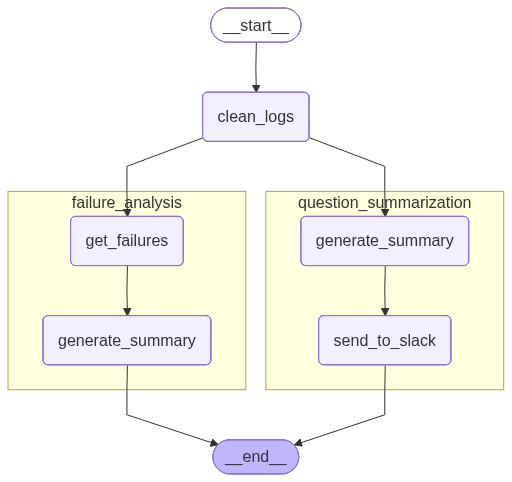

In [22]:
# Adding our sub-graphs to parent(main, major) graph as nodes.
# Our sub-graphs run in parallel and returns the same key, so it`s needs to have reducer 'operator.add'` to combine incoming values from each sub-graph.

# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs


# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]
    
def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)
graph = entry_builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
# example logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
3Map-reduce. (sub-operations)

In [ ]:
Map-reduce operations essential for efficient task decomposition and parallel processing.
Map - break task into smaller sub-tasks, parallel processing each sub-task.
Reduce - Union/aggregate results of all completed parallelized sub-tasks. 

Let`s design system that (not my idea) map, create set of jokes, reduce, pick the best joke of list. LLM need here for generation & selection. 
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}.""";
joke_prompt = """Generate a joke about {subject}""";
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}""";

Parallelizing generation. Entry point of graph will take user input topic, produce list of joke topics, send each joke topic to our above generation node.
State here has 'jokes'` key which accumalate/store jokes from parallelized joke generation.

import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
class Subjects(BaseModel):
    subjects: list[str]
class BestJoke(BaseModel):
    id: int
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


We use 'Send' (below) to create joke for each subject, it can automatically parallelize joke generation for any number of subjects. 
'generate_joke' is name, {"subject": s} is state to send.
'Send'; allow you to pass any state to 'generate_joke';, it doesn`t have to allign with 'OverallState'.
Here 'generate_joke'; using its own internal state and we can fill up/populate this through 'Send';
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

In [ ]:
Joke generation (map).
Let`s define node that will create jokes 'generate_jokes';. We write them back out to jokes in 'OverallState';. 

class JokeState(TypedDict):
    subject: str
class Joke(BaseModel):
    joke: str
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

Best joke selection (reduce).

def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

In [45]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

But it`s on KimiK2, and with small editted code, but logic same
for s in app.stream({"topic": "FC Barcelona"}):
    print(s)

{'generate_topics': {'subjects': ['History and Founding of FC Barcelona', 'Legendary Players and Coaches', 'El Clásico Rivalry with Real Madrid']}}
{'generate_joke': {'jokes': ['FC Barcelona was founded in 1899 by Joan Gamper—because even back then, someone needed a club that could pass the ball… and a DNA test.']}}
{'generate_joke': {'jokes': ['Why did the Real Madrid fan bring a ladder to El Clásico? Because he heard Barça were on another level!']}}
{'generate_joke': {'jokes': ['Legendary coach Bear Bryant, Vince Lombardi, and Sir Alex Ferguson walk into a bar—every stool immediately stands at attention and starts running laps.']}}
{'best_joke': {'best_selected_joke': 'Why did the Real Madrid fan bring a ladder to El Clásico? Because he heard Barça were on another level!'}}


In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------'''

In [ ]:
4Research assistant powered by LangGraph.

In [ ]:
Goal is to build a lightweight MAS (multiagent) on base of chat models that customizes research process. We want here to have at least these points 

'Source selection', users can choose any set of input sources for their research.
                                                             
'Planning', users provide a topic and system generates a team of AI analysts, each of these perform/focus on 1 sub-topic; \n
For clalification/refine these sub-topics before research begins We will using Human-in-loop.

'LLM usage/utilization', each analyst will conduct in-depth interviews with AI expert using selected sources; \n
Interview wiil be multi-turn conversation, and we want to extract detailed insights/info; \n
These interviews will be captured, or will going using 'sub-graphs'; with their internal state.

'Research process', in parallel experts will gather info to answer analyst question; \n
At the same time (simultaneously) all interviews will be conducted through 'map-reduce'.

'Output format', gathered insights from each interview will be synthesized into final report; \n
We will use customizable prompts for report, including flexible output format.

In [ ]:
Below will be - 

analyst_instructions, creating set of AI analysts;
question_instructions, instructions for analyst to interview an expert on some topic; 
search_instructions, generating query of conversation;
answer_instructions, expert(he) being interviewed by analyst;
section_writer_instructions, creating section of report based on source documents;
report_writer_instructions, creating report by team of analysts;
intro_conclusion_instructions, for writing intro/conclusion section;
@create_analysts;
@human_feedback;
@should_continue, return next node to execute;
@generate_question; 
@search_web; 
@search_wikipedia;
@generate_answer, answer questions in `answer_instructions`;
@save_interview;
@route_messages, route between question & answer;
@write_section;
@initiate_all_interviews, `map` step when running each interview sub-graph;
@write_report;
@write_introduction;
@write_conclusion;
@finalize_report, `reduce` step where combine all sections;
GenerateAnalystsState;
ResearchGraphState;
Overall 2 sub-graphs and 1 main graph.

In [4]:
'''Generate analysts, create them using human-in-loop.'''

from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",)
    name: str = Field(
        description="Name of the analyst.")
    
    role: str = Field(
        description="Role of the analyst in the context of the topic.",)
    
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",)
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",)

class GenerateAnalystsState(TypedDict):
    topic: str                  # Research topic
    max_analysts: int           # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst]     # Analyst asking questions


from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    
    """ No-op node that should be interrupted on """
    
    pass

def should_continue(state: GenerateAnalystsState):
    
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

In [5]:
'''Example - 3 ~random analysts and info about them'''
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run graph until first interruption                                                      !not updates
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Maya Patel
Affiliation: Institute for Advanced AI Systems
Role: Technical Performance Analyst
Description: Focuses on benchmarking LangGraph's runtime efficiency, latency, and resource utilization compared to alternative agent frameworks. Concerned with scalability, concurrency handling, and real-time responsiveness for high-throughput applications.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience & Productivity Analyst
Description: Evaluates how LangGraph's abstractions, tooling, and documentation improve developer onboarding, code maintainability, and rapid prototyping. Emphasizes ergonomics, learning curve, and integration with existing Python ecosystems.
--------------------------------------------------
Name: Sofia Ramirez
Affiliation: TechVentures Consulting Group
Role: Business & Strategic Value Analyst
Description: Assesses the economic impact of adopting LangGraph, including cost sav

In [6]:
'''Example - 3 ~random analysts and info about them From previous cell, and + 3 analysts, 
when one of them three somehow (we don`t care) connected to entrepreneurship. sum=6'''
# Now we update 'state' as if we are human_feedback node (but we aren`t logically)
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

# Continue graph execution                       !not updates
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Maya Patel
Affiliation: Institute for Advanced AI Systems
Role: Technical Performance Analyst
Description: Focuses on benchmarking LangGraph's runtime efficiency, latency, and resource utilization compared to alternative agent frameworks. Concerned with scalability, concurrency handling, and real-time responsiveness for high-throughput applications.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience & Productivity Analyst
Description: Evaluates how LangGraph's abstractions, tooling, and documentation improve developer onboarding, code maintainability, and rapid prototyping. Emphasizes ergonomics, learning curve, and integration with existing Python ecosystems.
--------------------------------------------------
Name: Sofia Ramirez
Affiliation: TechVentures Consulting Group
Role: Business & Strategic Value Analyst
Description: Assesses the economic impact of adopting LangGraph, including cost sav

In [7]:
# If we`re satisfied, we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": further_feedack}, as_node="human_feedback")
# Continue graph execution to the  end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
final_state.next

()

In [8]:
# PostCheck
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Maya Patel
Affiliation: Stanford University, Computer Science Department
Role: Academic Researcher
Description: Focuses on advanced agent architectures, scalability, and theoretical foundations of graph-based frameworks. Concerned with rigor, reproducibility, and long-term research impact.
--------------------------------------------------
Name: Liam O'Connor
Affiliation: GlobalTech Enterprises, Chief Technology Officer
Role: Enterprise CTO
Description: Evaluates technology adoption for large-scale deployments, integration with legacy systems, security, compliance, and ROI. Prioritizes operational stability and cost efficiency.
--------------------------------------------------
Name: Aisha Rahman
Affiliation: NeuroFlow AI, Co‑Founder & Head of Engineering
Role: Startup Founder / Engineer
Description: Provides an entrepreneurial perspective on rapid prototyping, time‑to‑market, and how LangGraph can give a competitive edge for early‑stage AI products. Focuses on agility, fundi

In [ ]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------'''

In [9]:
'''Conduct interview. Generate question, and analyst will ask questions to expert'''


import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int                       # Number turns of conversation
    context: Annotated[list, operator.add]   # Source docs
    analyst: Analyst                         # Analyst asking questions
    interview: str                           # Interview transcript
    sections: list                           # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")


question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


def generate_question(state: InterviewState):
    
    """ Node to generate a question """
    
    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    # Write messages to state
    return {"messages": [question]}

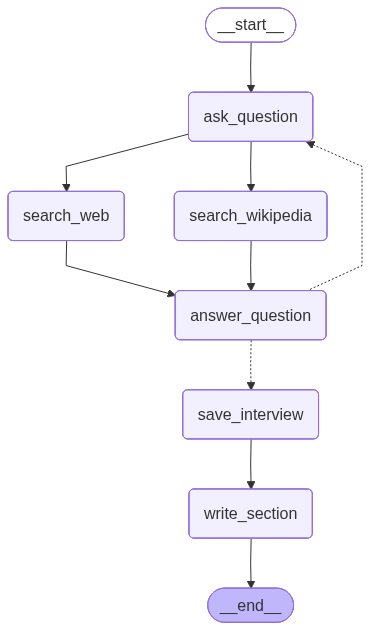

In [10]:
'''Generate answer, Parallelization. Expert will gather info from different sources In parallel to answer questions''' 

# Web search tool
from langchain_tavily import TavilySearch  
tavily_search = TavilySearch(max_results=3)
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader


'''Create nodes for search and wiki; also create node to answer analyst questions; create nodes to fully save interview and write summary of it'''

from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) #updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 


def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

    
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""


def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
        
    return "ask_question"


section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

    
def write_section(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


# actual graph #
# nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [11]:
'''Pre-Final, small essay'''
# Run interview by passing index of the llama 3.1 paper, related to our topic 

from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Graph‑Centric Agent Architectures: Scaling Multi‑Agent Systems with Rigor and Reproducibility  

### Summary  
The rapid evolution of large‑language‑model (LLM) tooling has foregrounded graph‑based frameworks as a theoretical and practical foundation for next‑generation AI agents. LangGraph, a graph‑oriented extension of the LangChain ecosystem, exemplifies this shift by offering explicit state management, real‑time streaming, and a modular composition model that aligns with microservice principles.  

1. **Stateful, Scalable Workflows** – LangGraph’s graph architecture enables developers to encode complex, branching logic while preserving mutable state across hops, a capability that traditional chain‑based pipelines lack. This design supports real‑time streaming of intermediate results, facilitating responsive user experiences and fine‑grained monitoring [1].  

2. **Microservice‑First Composition** – Community observations highlight that LangGraph performs best when decomposed into small, focused graphs that interoperate as independent services rather than monolithic pipelines. Such granularity improves fault isolation, enables independent scaling, and simplifies reproducibility of experimental runs [2].  

3. **Complementarity with LangChain and LangSmith** – LangGraph can be layered atop LangChain’s chain abstractions, allowing teams to retain the simplicity of linear pipelines while leveraging dynamic graph execution for adaptive tasks. Integrated tracing via LangSmith provides end‑to‑end observability, essential for rigorous evaluation and debugging of agentic workflows [4][5].  

4. **Comparative Landscape** – Autogen, Microsoft’s open‑source multi‑agent framework, excels at orchestrating specialized agents as a coordinated team, whereas LangGraph shines in constructing flexible, stateful workflows that react to evolving contexts. The distinction underscores a design trade‑off: Autogen prioritizes agent collaboration semantics, while LangGraph emphasizes workflow adaptability [3].  

5. **Production‑Ready Deployments** – Real‑world adoption demands robust DevOps pipelines. DuploCloud’s Automation Studio abstracts away the orchestration complexity of LangGraph, delivering secure, production‑grade agents without manual infrastructure management [1]. Moreover, deploying LangGraph agents to Kubernetes using asynchronous FastAPI endpoints demonstrates superior scalability and responsiveness for concurrent workloads, confirming the framework’s suitability for large‑scale, cloud‑native environments [6].  

Collectively, these insights suggest that graph‑centric agent architectures not only advance theoretical understanding of stateful LLM interactions but also provide a reproducible, scalable pathway for long‑term research impact. By treating each graph node as a microservice, researchers can isolate variables, benchmark performance, and iteratively refine components, thereby meeting the rigor demanded by the AI community.  

### Sources  
[1] https://duplocloud.com/blog/langchain-vs-langgraph/  
[2] https://www.reddit.com/r/LangChain/comments/1lumwxr/pipeline-of-agents-with-langgraph_why_monolithic/  
[3] https://www.truefoundry.com/blog/autogen-vs-langgraph  
[4] https://www.langchain.com/langgraph  
[5] https://docs.langchain.com/langsmith/trace-with-langgraph  
[6] https://medium.com/@yuxiaojian/how-to-deploy-langgraph-agents-to-kubernetes-b3216d0cc961

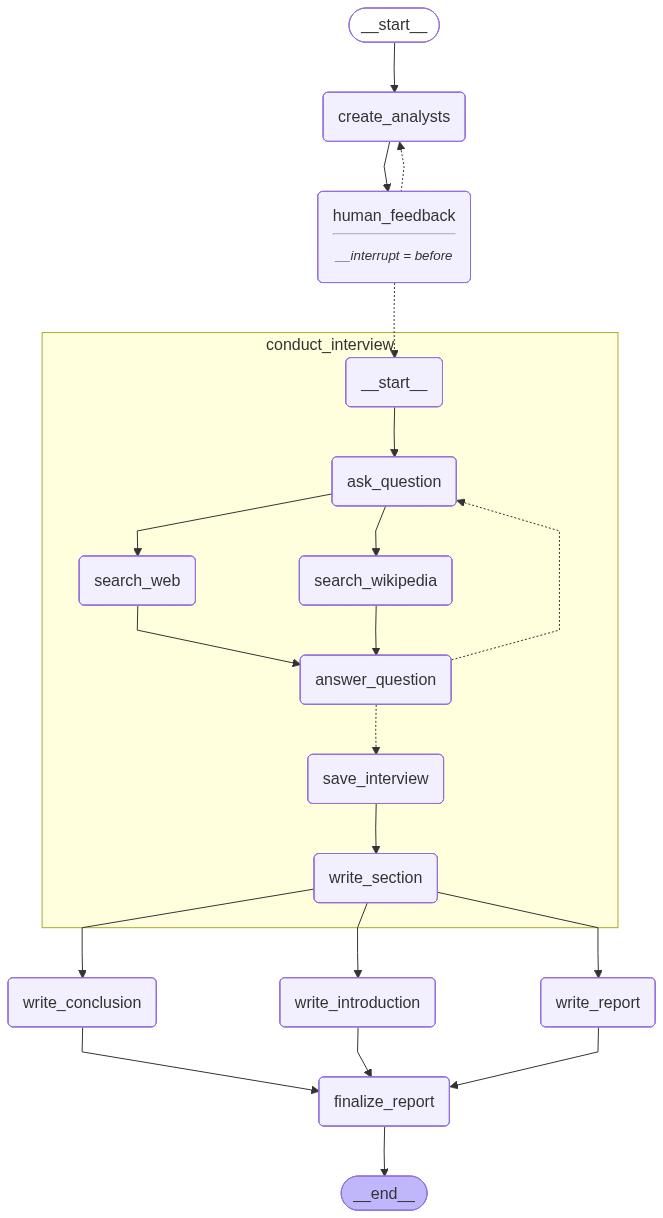

In [12]:
'''Parallelize interviews, Map-Reduce. Parallelize via/through Send() API, map step; combine them into report body in reduce step.
We add final step to write intro and conclusion to final report'''

import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str                                # Research topic
    max_analysts: int                         # Number of analysts
    human_analyst_feedback: str               # Human feedback
    analysts: List[Analyst]                   # Analyst asking questions
    sections: Annotated[list, operator.add]   # Send() API key
    introduction: str                         # Introduction for the final report
    content: str                              # Content for the final report
    conclusion: str                           # Conclusion for the final report
    final_report: str                         # Final report

from langgraph.types import Send 

def initiate_all_interviews(state: ResearchGraphState):
    
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

        
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""


def write_report(state: ResearchGraphState):
    
    """Writing report"""
    
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    
    return {"content": report.content}

    
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    """Writing introduction"""
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):

    """Writing conclusion"""
    
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    
    return {"conclusion": conclusion.content}


def finalize_report(state: ResearchGraphState):
    
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write intro or conclusion """
    
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
        
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
        
    return {"final_report": final_report}


# actual graph #
# add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [13]:
'''Example - 3 ~random analysts. As was before actually'''
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Maya Patel
Affiliation: Institute for AI Systems Engineering
Role: Technical Performance Analyst
Description: Specializes in evaluating runtime efficiency, scalability, and resource utilization of agent frameworks. Provides deep benchmarking of LangGraph's graph execution model, latency, throughput, and integration with hardware accelerators.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience Analyst
Description: Focuses on the usability, composability, and tooling ecosystem around LangGraph. Analyzes learning curve, debugging support, documentation quality, and how the framework accelerates prototyping for AI engineers.
--------------------------------------------------
Name: Priya Singh
Affiliation: TechVentures Consulting
Role: Business Strategy Analyst
Description: Assesses the strategic and financial impact of adopting LangGraph in enterprise settings. Examines ROI, time‑to‑market, cost‑sa

In [14]:
'''Example - 3 ~random analysts + 3 more people, and One of this trio will be `CEO of gen ai native startup`'''
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

# Check this
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Maya Patel
Affiliation: Institute for AI Systems Engineering
Role: Technical Performance Analyst
Description: Specializes in evaluating runtime efficiency, scalability, and resource utilization of agent frameworks. Provides deep benchmarking of LangGraph's graph execution model, latency, throughput, and integration with hardware accelerators.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience Analyst
Description: Focuses on the usability, composability, and tooling ecosystem around LangGraph. Analyzes learning curve, debugging support, documentation quality, and how the framework accelerates prototyping for AI engineers.
--------------------------------------------------
Name: Priya Singh
Affiliation: TechVentures Consulting
Role: Business Strategy Analyst
Description: Assesses the strategic and financial impact of adopting LangGraph in enterprise settings. Examines ROI, time‑to‑market, cost‑sa

In [15]:
# If all good we update
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ae961-6ad7-6f27-8004-64daf621a8e1'}}

In [17]:
'''VERY important part - stream updates of graph state'''

'''Without this rate limiter i can`t inference, api crushing - SO, must be there. Which model exactly is not so important'''
from langchain_core.rate_limiters import InMemoryRateLimiter
rate_limiter = InMemoryRateLimiter(requests_per_second=0.066,check_every_n_seconds=0.1,max_bucket_size=5,)
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0, rate_limiter=rate_limiter, max_retries=2,)
model = ChatGroq(model="openai/gpt-oss-120b", temperature=0, rate_limiter=rate_limiter, max_retries=2,)


# important this #
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [28]:
'''FINAL'''
# Personally works with gpt-oss 120b only
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

<think>
Okay, the user wants me to write an introduction for their report on the benefits of adopting LangGraph as an agent framework. Let me start by understanding the key points they want to highlight. The sections provided mention architectural advantages, modularity, multi-agent workflows, integration with LLMs, and specific benefits like quick prototyping and cost efficiencies.

First, I need a compelling title. The user mentioned using a # header for the title. Maybe something like "LangGraph: Revolutionizing AI Agent Development with Modular, Scalable Frameworks". That captures the essence of innovation and scalability.

Next, the introduction should preview all the sections. The user wants it to be around 100 words, so I need to be concise. Start by stating the importance of AI agents in modern applications. Then introduce LangGraph as a solution with its key features: modularity, multi-agent workflows, LLM integration. Mention the benefits like rapid iteration, simplified debugging, and seamless LLM integration. Finally, set up the structure of the report by listing the sections it will cover.

I need to ensure that the introduction flows smoothly, connecting each benefit to the sections. Also, avoid any technical jargon to keep it accessible. Check that all the key points from the provided sections are included without going into too much detail. Make sure to use markdown formatting as specified, with the title as a # header and the introduction under ## Introduction. No preambles, just the content. Let me piece this together now.
</think>

# LangGraph: Revolutionizing AI Agent Development with Modular, Scalable Frameworks  
## Introduction  
LangGraph is a next-generation agent framework designed to address the complexity of modern AI applications. By combining modularity, multi-agent orchestration, and seamless integration with large language models (LLMs), it empowers developers to build adaptive, production-ready systems. This report explores LangGraph’s architectural advantages, including its supervisor pattern for multi-agent workflows, low-code prototyping capabilities, and tools for natural language understanding. Key benefits such as rapid iteration, simplified debugging, and cost-efficient deployment are analyzed alongside real-world use cases. The report also evaluates LangGraph’s role in accelerating time-to-market, reducing engineering overhead, and enabling complex agent-based workflows. For enterprises seeking scalable, future-proof AI solutions, LangGraph offers a compelling foundation to innovate in dynamic markets.

---



LangGraph is emerging as a decisive framework for building and scaling AI agents, offering a blend of architectural robustness and business‑focused advantages that accelerate product development. Its graph‑based design introduces explicit state control, enabling developers to compose modular agents, register tools, and iterate rapidly while maintaining clear visibility into workflow execution [1][2]. This modularity supports complex multi‑agent collaborations through a supervisor pattern, allowing specialized agents to coordinate under a central orchestrator [3]. The result is a reduction in debugging time and a smoother path from prototype to production [4].

From a business perspective, LangGraph shortens development cycles by providing high‑level primitives and pre‑built components that streamline natural language understanding and generation [2]. Teams can prototype sophisticated, stateful agents in days rather than weeks, translating into faster time‑to‑market and lower engineering overhead. The framework’s seamless integration with large language models (LLMs) further reduces the need for custom glue code, delivering cost efficiencies at scale [2].

Strategic differentiation is another key benefit. By leveraging graph‑oriented workflows, startups can build unique, scalable AI applications—such as long‑running retail automation agents or adaptive customer‑service bots—that stand out from competitors relying on linear pipelines [5][6]. This capability fosters ecosystem lock‑in: as developers, partners, and customers adopt LangGraph’s open‑source stack, switching costs rise and a vibrant community forms around the framework [5][6].

Talent acquisition is also positively impacted. Engineers are drawn to cutting‑edge, graph‑centric AI development environments that promise exposure to state‑of‑the‑art multi‑agent systems, enhancing a company’s ability to attract and retain top AI talent [5][6]. Moreover, LangGraph aligns with emerging AI agent standards, ensuring that early adopters remain compatible with future advancements and can evolve their roadmaps without costly re‑architecting [7].

In practice, LangGraph’s explicit state management simplifies the orchestration of long‑running, multi‑step agents, reducing the need for external workflow engines and minimizing operational complexity [8]. When evaluated alongside alternatives such as Temporal or Dagster, LangGraph offers a compelling balance of flexibility and built‑in AI capabilities, making it a preferred choice for projects with clear business use cases and measurable success metrics [9].

Collectively, these architectural and strategic strengths position LangGraph as a catalyst for rapid, cost‑effective, and differentiated AI product development, delivering tangible value to both startups and established enterprises.


---

<think>
Okay, the user wants me to write the conclusion for their report on the benefits of adopting LangGraph as an agent framework. Let me start by recalling the key points from the sections provided. The report covers architectural advantages, modularity, multi-agent workflows, integration with LLMs, and specific benefits like quick prototyping and cost efficiencies.

First, the conclusion needs to recap all these sections concisely. I should mention the modularity and how it allows for rapid iteration and tool registration. Then, the supervisor pattern for multi-agent systems is important. Also, the seamless integration with LLMs and the low-level primitives versus high-level components. The benefits listed include quick prototyping, debugging, multi-agent support, and LLM integration.

I need to make sure the conclusion is around 100 words and uses markdown formatting. The user specified a crisp and compelling conclusion, so I should avoid fluff. Start with a strong statement about LangGraph's role in AI agent development. Then summarize each key point briefly. End with a forward-looking statement about its impact on future applications.

Check the sources to ensure all main points are covered. Make sure the conclusion doesn't introduce new information but synthesizes the existing content. Use the section headers as per the user's instructions: ## Conclusion as the header. No preamble, just the conclusion. Keep it tight and impactful.
</think>

## Conclusion  
LangGraph emerges as a transformative framework for AI agent development, offering architectural flexibility, modularity, and seamless LLM integration. Its supervisor pattern enables scalable multi-agent workflows, while low-level primitives and high-level components empower developers to balance customization and efficiency. By accelerating prototyping, simplifying debugging, and supporting complex coordination, LangGraph reduces engineering overhead and time-to-market for agent-based systems. As enterprises demand adaptive, production-ready AI solutions, LangGraph’s structured approach to state management and workflow orchestration positions it as a cornerstone for next-generation applications—from autonomous research assistants to enterprise automation. Adopting LangGraph not only future-proofs development pipelines but also unlocks new possibilities for innovation in AI-driven workflows.

## Sources
[1] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[2] https://www.langchain.com/langgraph  
[3] https://medium.com/@ashuashu20691/anatomy-of-a-multi-agent-system-oracle-langgraph-real-world-use-cases-f9ed12b67231  
[4] https://langchain-ai.github.io/langgraphjs/agents/overview/  
[5] https://interviewkickstart.com/blogs/articles/langgraph-for-retail-ai-agent  
[6] https://www.ibm.com/think/topics/langgraph  
[7] https://orq.ai/blog/langchain-vs-langgraph  
[8] https://kinde.com/learn/ai-for-software-engineering/ai-devops/orchestrating-multi-step-agents-temporal-dagster-langgraph-patterns-for-long-running-agents/  
[9] https://www.linkedin.com/posts/atiqmansoori7_day-1-introduction-to-langgraph-activity-7379727205288804352-aZJ8

In [ ]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------'''

In [ ]:
###############################################################################################################################################################
###############################################################################################################################################################
###############################################################################################################################################################

In [ ]:
1Memory store.

In [ ]:
'LangGraph Memory Store' is way to save and retrieve long-term memories/information across threads. This is opensource class for persostent key-value stores
Chatbot uses both 'short / long -term (within-thread)'; memory.
Focus will be on long-term 'semanthic'; memory, it is facts about user. It will save memory `in hot path` as user chatting with bot.

import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

During storing objects in store/vault/storage we provide: 'namespace'; for object, object 'key', object 'value'.
We using 'put'; method to save object to store by 'namespace'; and 'key';.

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")
# Save a memory to namespace as key and value
key = str(uuid.uuid4())
# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}
# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

Use 'search'; to retrieve objects from store by 'namespace';, returns a list.
# Search 
memories = in_memory_store.search(namespace_for_memory)
type(memories)
# Metadata 
memories[0].dict()
# The key, value
print(memories[0].key, memories[0].value)

Also can be used 'get'; to retrieve object by 'namespace'; and 'key';.
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

In [6]:
For 'short-term memory'; we will use 'checkpointer';. For 'long-term memory'; we will use LG Store.

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.memory import InMemoryStore

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""


# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

    
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()
# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

In [7]:
When interacting with chatbot we supply to him 'thread_id'(for short) and 'user_id'(for long) - so they work together.

config = {"configurable": {"thread_id": "1", "user_id": "1"}}
# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! Nice to meet you—I'll remember that. What can I help you with today?


In [8]:
input_messages = [HumanMessage(content="I like to bike around San Francisco")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

Nice—San Francisco is a fantastic city for biking (as long as you don’t mind the occasional hill that feels like a mountain). Any favorite routes or spots you usually hit, Lance?


In [10]:
Because of we using 'MemorySaver'; checkpointer, it`s saves chat history to thread. So let`s look at chat history saved to thread.

thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

And also our memory was saved to store.
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! Nice to meet you—I'll remember that. What can I help you with today?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

Nice—San Francisco is a fantastic city for biking (as long as you don’t mind the occasional hill that feels like a mountain). Any favorite routes or spots you usually hit, Lance?


{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': ''},
 'created_at': '2025-10-22T18:49:38.394713+00:00',
 'updated_at': '2025-10-22T18:49:38.394722+00:00'}

In [11]:
Create new thread with same 'user_id'. We should see chatbot remembered user`s profile and used it to personalize response.
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
#doesn't work but it should idk

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi! Since I don’t have any memory of your past rides or preferences yet, I’ll give you a few “can’t-miss” options that cover different styles—pick the one that sounds most like you, or tell me more about what you like and I’ll narrow it down next time.

1. If you want scenery & a mellow cruise  
   – Car-free paved path: Kettle Valley Rail Trail (Okanagan, BC) or the American equivalent, the Hiawatha Trail (Idaho/Montana border). Gentle grades, trestle bridges, tunnels, big pay-off views.

2. If you like flowy single-track but aren’t looking to break bones  
   – Bentonville, Arkansas. It’s become the “mountain-bike capital of the Midwest” with beautifully built green/blue loops, bike-friendly town, and rental bikes everywhere.

3. If you’re training for distance or want big cl

In [ ]:
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################

In [ ]:
2Profile schema.

In [ ]:
Our chatbot save memories as string, but in production we usually want memories to have structure. e. g. memories can be single or continuously updated schema.
In our cae we want memories to be single user profile. We will extend chatbot to save semantic memories to single user profile.

from typing import TypedDict, List
class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

LG store accepts any .py dictionary as 'value'.
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

We use put method to save 'TypedDict'; to store.
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()
user_id = "1"
namespace_for_memory = (user_id, "memory")
# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

Use 'search'; to retrieve objects from store by namespace. Or 'get'.
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

In [16]:
'''
In our chatbot we want to create memories from user chat. Let`s pass 'UserProfile'; schema to 'with_structured_output'; method.
We can invoke model with list of messages and get structured output corresponds/conforms to our schema.
Now let`s use this with our bot. For this we need to change 'write_memory'; function. '''



from typing import TypedDict, List
class UserProfile(TypedDict):
    user_name: str  
    interests: List[str]

from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage                 #without this error in Groq
model_with_structure = model.with_structured_output(UserProfile, method="json_schema")
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)


builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()
# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()


graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

In [17]:
# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hi Lance! Great to meet you. San Francisco is such a fun city to bike—those hills are no joke, but the views make it worth it. And the bakery scene is incredible. Have you found any favorites yet? I’ve heard good things about Tartine and Arsicault, but I’d love to know which spots you’ve discovered on your rides.


In [18]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance',
 'interests': ['biking around San Francisco', 'eating at bakeries']}

In [20]:
Pydantic model w/ user preferences.

from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [22]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

In [ ]:
Trustcall is open-source lib that updating JSON schemas, by LangChain ofc.

# random Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

We use 'create_extractor'; and pass it in model as well as our schema, but this as tool.
We can supply schema in various ways. e.g. we can pass JSON object or .py dict or Pydantic model. 
TrustCall uses tool calling to produce structured output from input list of messages. To force TrustCall to do this we can include schema name in tool_choice arg.

from trustcall import create_extractor 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")
# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile")
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

When invoke() extractor we get: 'messages', list of AImessages that contain tool calls; 'responses', resulting parsed tool calls that match our schema;
'response_metadata'.

for m in result["messages"]: 
    m.pretty_print()
schema = result["responses"]
schema
schema[0].model_dump()
result["response_metadata"]

...

In [ ]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  
for m in result["messages"]: 
    m.pretty_print()

In [30]:
'''TrustCall in bot to create and update memory profile'''

from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()
# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

In [32]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="Hi, my name is Lance")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

input_messages = [HumanMessage(content="I like to bike around San Francisco")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi again, Lance! I remember you from before. What’s on your mind today?


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': ''}}

In [ ]:
# The user profile saved as a JSON object
existing_memory.value
# {'user_name': 'Lance',
#  'user_location': 'San Francisco',
#  'interests': ['biking']}

In [ ]:
We also can save memories to collection rather single profile.

In [ ]:
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################

In [ ]:
5Memory Agent.

In [ ]:
We will build agent with long-term memory, he will help us manage ToDo list. He will decide whether save memories or not.
He can decide to save either user profile or  collection of ToDo items. Also he will manage procedural memory or only semantic.

In [27]:
'''Adding visibility to TrustCall'''

from pydantic import BaseModel, Field

from pydantic import BaseModel, Field, ConfigDict

class Memory(BaseModel):
    """Single user memory unit."""
    content: str = Field(
        ...,
        description="The main content of the memory. E.g., 'User expressed interest in learning about French.'"
    )
    # Общий description для инструмента (function.description)
    model_config = ConfigDict(
        title="Memory",
        description="Schema for extracting a single user memory from conversation."
    )

class MemoryCollection(BaseModel):
    """Collection of user memories."""
    memories: list[Memory] = Field(
        ...,
        description="A list of memories about the user."
    )
    model_config = ConfigDict(
        title="MemoryCollection",
        description="Schema for extracting a list of user memories from conversation."
    )


'''And add listener to extractor, this will pass runs from extractor to class Spy'''

from trustcall import create_extractor

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):

        stack = [run]
        while stack:
            r = stack.pop()
            stack.extend(r.child_runs or [])
            if r.run_type == "chat_model":
          
                try:
                    gens = r.outputs.get("generations", [])
                    if gens and gens[0] and gens[0][0]:
                        msg = gens[0][0]["message"]
                        tool_calls = msg.get("kwargs", {}).get("tool_calls") or msg.get("tool_calls")
                        if tool_calls:
                            self.called_tools.append(tool_calls)
                except Exception:
                    pass

# Initialize the spy
spy = Spy()
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [30]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

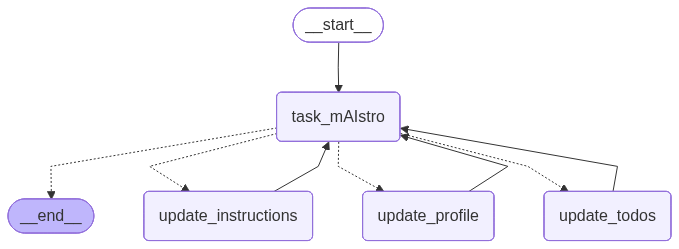

In [4]:
'''ReAct agent''' #I'm made it by myself cause in Colab ipynb always 
#BadRequestError: Error code: 400 - {'error': {'message': "'tools.0.function.description' : Value is not nullable", 'type': 'invalid_request_error'}}
'''
Agent - assistant for creating and managing ToDo list.
Agent can make decision to update 3 types of long-term memory:
1 Create or update user_profile with general user information.
2 Add or update items in ToDo list collection.
3 Update own instructions on how to update items to ToDo list.
'''



import uuid
from typing import TypedDict, Literal
from IPython.display import Image, display
from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_core.tools import tool
from langchain_core.tools import StructuredTool


class Spy:
    def __init__(self):
        self.called_tools = []
        
    def __call__(self, run):
        self._walk(run)
        
    def _walk(self, run):
        self._collect(run)
        for c in getattr(run, "child_runs", []) or []:
            self._walk(c)
            
    def _collect(self, run):
        out = getattr(run, "outputs", None)
        if not out or not isinstance(out, dict):
            return
            
        gens = out.get("generations") or []
        if not isinstance(gens, list):
            gens = [gens]
            
        flat = []
        for g in gens:
            items = g if isinstance(g, list) else [g]
            
            for it in items:
                msg = it.get("message") if isinstance(it, dict) else getattr(it, "message", None)
                calls = None
                
                if isinstance(msg, dict):
                    kw = msg.get("kwargs") or msg.get("additional_kwargs") or {}
                    calls = kw.get("tool_calls") or msg.get("tool_calls")
                    
                else:
                    calls = getattr(msg, "tool_calls", None) or getattr(getattr(msg, "additional_kwargs", {}), "get", lambda *_: None)("tool_calls")
                    
                if calls:
                    flat.extend(calls if isinstance(calls, list) else [calls])
                    
        if flat:
            self.called_tools.append(flat)


def extract_tool_info(called_tools, target_tool: str) -> str:
    if not called_tools:
        return "updated todos"
        
    for batch in called_tools:
        for call in batch:
            name = call.get("function", {}).get("name") or call.get("name")
            
            if name and target_tool.lower() in name.lower():
                args = call.get("function", {}).get("arguments") or call.get("arguments")
                return f"{target_tool} updated: {args}" if args else "updated todos"
                
    return "updated todos"



class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(description="User connections", default_factory=list)
    interests: list[str] = Field(description="User interests", default_factory=list)

class ToDo(BaseModel):
    """A single actionable ToDo item extracted from conversation"""
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time in minutes.", default=None)
    deadline: Optional[datetime] = Field(description="Deadline if applicable.", default=None)
    solutions: list[str] = Field(description="Concrete actionable solutions or options", min_items=1, default_factory=list)
    status: Literal["not started", "in progress", "done", "archived"] = Field(description="Current task status", default="not started")

class UpdateMemoryArgs(BaseModel):
    """" Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions'] = Field(description="Which memory bucket to update.")
@tool("UpdateMemory", args_schema=UpdateMemoryArgs)
def update_memory(update_type: str) -> str:
    """Signal which memory to update: 'user' profile, 'todo' list, or 'instructions'."""
    return f"will update: {update_type}"

profile_extractor = create_extractor(model, tools=[Profile], tool_choice="Profile")



# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""


# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""



#Nodes                                  !important symbol
def task_mAIstro(state: MessagesState, *, config: RunnableConfig, store: BaseStore):
    
    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    mems = store.search(("profile", user_id))
    user_profile = mems[0].value if mems else None
    
    # Retrieve task memory from the store
    mems = store.search(("todo", user_id))
    todo = "\n".join(f"{m.value}" for m in mems)
    
    # Retrieve custom instructions
    mems = store.search(("instructions", user_id))
    instructions = mems[0].value if mems else ""
    sys_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([update_memory], parallel_tool_calls=False).invoke([SystemMessage(content=sys_msg)] + state["messages"])
    
    return {"messages": [response]}

def update_profile(state: MessagesState, *, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(it.key, tool_name, it.value) for it in existing_items] if existing_items else None)

    # Merge the chat history and the instruction
    instr = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = list(merge_message_runs(messages=[SystemMessage(content=instr)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace, rmeta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))
    tool_calls = state["messages"][-1].tool_calls
    
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id": tool_calls[0]["id"]}]} if tool_calls else {}

def update_todos(state: MessagesState, *, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(it.key, tool_name, it.value) for it in existing_items] if existing_items else None)

    # Merge the chat history and the instruction
    instr = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = list(merge_message_runs(messages=[SystemMessage(content=instr)] + state["messages"][:-1]))

    
    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()

    
    # Create the Trustcall extractor for updating the ToDo list
    todo_extractor = create_extractor(model, tools=[ToDo], tool_choice=tool_name, enable_inserts=True).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace, rmeta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))

    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state["messages"][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id": tool_calls[0]["id"]}]} if tool_calls else {}

def update_instructions(state: MessagesState, *, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    namespace = ("instructions", user_id)
    existing = store.get(namespace, "user_instructions")

    # Format the memory in the system prompt
    sys_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing.value if existing else None)
    new_memory = model.invoke([SystemMessage(content=sys_msg)] + state["messages"][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    store.put(namespace, "user_instructions", {"memory": new_memory.content})
    tool_calls = state["messages"][-1].tool_calls
    
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id": tool_calls[0]["id"]}]} if tool_calls else {}

def route_message(state: MessagesState) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    
    message = state["messages"][-1]
    if not getattr(message, "tool_calls", None):
        return END
    t = message.tool_calls[0]["args"]["update_type"]
    if t == "user":
        return "update_profile"
    if t == "todo":
        return "update_todos"
    if t == "instructions":
        return "update_instructions"
    return END



builder = StateGraph(MessagesState)
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
store = InMemoryStore()
across_thread_memory = store
# Checkpointer for short-term (within-thread) memory
checkpointer = MemorySaver()
within_thread_memory = checkpointer

graph = builder.compile(checkpointer=checkpointer, store=store)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

In [16]:
# We supply a thread ID for short-term memory & user ID for long-term memory 

input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Lance. I live in SF with my wife. I have a 1 year old daughter.
================================== Ai Message ==================================

Got it - thanks for sharing that information about yourself and your family!


In [17]:
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (functions.UpdateMemory:4)
 Call ID: functions.UpdateMemory:4
  Args:
    update_type: todo
================================= Tool Message =================================

updated todos
================================== Ai Message ==================================

I've added booking swim lessons for your daughter to your todo list. Would you like me to help you research any swim schools in the SF area, or do you already have somewhere in mind?


In [11]:
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (functions.UpdateMemory:2)
 Call ID: functions.UpdateMemory:2
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it - I'll make sure to include specific local businesses and vendors when creating or updating your todo items. For the swim lessons, I should look up specific swim schools in SF rather than just saying "book swim lessons."


In [12]:
# Check for updated instructions

user_id = "Lance"
for memory in store.search(("instructions", user_id)):
    print(memory.value)

{'memory': '<updated_instructions>\nWhen creating or updating ToDo items, include specific local businesses / vendors.\n</updated_instructions>'}


In [14]:
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================

I've updated your todo list with the jammed Yale lock issue. Based on your preference for including specific local businesses, I've added several SF-based solutions including Yale's support number and two local locksmiths (Golden Gate Lock & Key and Mulberry Lock & Safe) with their phone numbers.


In [15]:
# Namespace for the memory to save

user_id = "Lance"
for memory in store.search(("todo", user_id)):
    print(memory.value)

{'task': 'Fix jammed electric Yale lock on door', 'time_to_complete': None, 'deadline': None, 'solutions': ['Contact Yale support at 1-800-810-2332 for troubleshooting', 'Call a local SF locksmith - Golden Gate Lock & Key (415-668-3663) or Mulberry Lock & Safe (415-864-3434)', 'Check if lock is under warranty and schedule authorized repair', 'Try resetting lock by removing batteries for 30 seconds then reinstalling'], 'status': 'not started'}


In [18]:
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}, "recursion_limit": 100} 
#                                                                   !delete if don't needed
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November. It will take me about 1 hour to get this done.")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November. It will take me about 1 hour to get this done.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (functions.UpdateMemory:5)
 Call ID: functions.UpdateMemory:5
  Args:
    update_type: todo
================================= Tool Message =================================

updated todos
================================== Ai Message ==================================

Perfect! I've updated the swim lessons task with a deadline of November 30th and estimated it will take about 1 hour to complete.


In [19]:
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service. Last i can do this is on 15 december.")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service. Last i can do this is on 15 december.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (functions.UpdateMemory:6)
 Call ID: functions.UpdateMemory:6
  Args:
    update_type: todo
================================= Tool Message =================================

updated todos
================================== Ai Message ==================================

I've added calling City Toyota to schedule car service to your todo list with a deadline of December 15th.


In [20]:
user_id = "Lance"
for memory in store.search(("todo", user_id)):
    print(memory.value)

{'task': 'Fix jammed electric Yale lock on door', 'time_to_complete': None, 'deadline': None, 'solutions': ['Contact Yale support at 1-800-810-2332 for troubleshooting', 'Call a local SF locksmith - Golden Gate Lock & Key (415-668-3663) or Mulberry Lock & Safe (415-864-3434)', 'Check if lock is under warranty and schedule authorized repair', 'Try resetting lock by removing batteries for 30 seconds then reinstalling'], 'status': 'not started'}
{'task': 'Book swim lessons for 1-year-old daughter', 'time_to_complete': 60, 'deadline': '2025-11-30T23:59:59', 'solutions': ['Contact Waterbabies Swim School SF (415-564-5200) - specializes in infant/toddler classes', 'Check out La Petite Baleen locations in SF (415-661-3112) - multiple locations around the city', 'Look into YMCA of SF Aquatics programs (415-777-9622) - family-friendly classes', 'Research UCSF Koret Center swim lessons (415-514-4600) - parent-child classes available'], 'status': 'not started'}
{'task': 'Call back City Toyota to 

In [21]:
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

Looking at your ToDo list, I can see you have a task that fits perfectly within your 30-minute window:

**Book swim lessons for 1-year-old daughter** (estimated time: 60 minutes) - This one is a bit over your available time, but you could make progress by calling one or two of the swim schools to get information about their programs and availability.

The other tasks don't have time estimates, but you could potentially:
- **Call City Toyota** to schedule car service - this might be quick if you get through right away
- **Contact Yale support** about your jammed lock - the initial troubleshooting call could be brief

Would you like me to help you tackle the swim lessons research first, or would you prefer to try one of the quicker calls?


In [22]:
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

Here are the swim schools from your ToDo list - all specialize in infant/toddler classes:

**Waterbabies Swim School SF** - (415) 564-5200
*Specializes in infant/toddler classes*

**La Petite Baleen** - (415) 661-3112  
*Multiple locations around the city*

**YMCA of SF Aquatics** - (415) 777-9622
*Family-friendly classes*

**UCSF Koret Center** - (415) 514-4600
*Parent-child classes available*

Since you have 30 minutes, you could probably call 2 of these to compare programs, pricing, and availability. Waterbabies and La Petite Baleen are both highly regarded for infant swim lessons in SF.


In [ ]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------'''

In [ ]:
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################

In [ ]:
ALL except for deployment is done.

In [ ]:
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################
##############################################################################################################################################################

In [6]:
from langchain_groq import ChatGroq
import os
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
from langchain_core.messages import HumanMessage
msg = HumanMessage(content="Hello world", name="Lancey Foux")
messages = [msg]
# llm.invoke(messages)
#invoke() - model activation / api call

_set_env("TAVILY_API_KEY")
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
# tavily_search.invoke("What is LangGraph?")
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))
for m in messages:
    m.pretty_print()
result = llm.invoke(messages)
type(result)
result

from langgraph.graph.message import add_messages
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")]
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")
add_messages(initial_messages , new_message)


from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))


def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b
llm_with_tools = llm.bind_tools([multiply])
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,)
builder.add_edge("tools", END)
graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))


def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.
    Args:
        a: first int
        b: second int
    """
    return a + b
def divide(a: int, b: int) -> float:
    """Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a / b
def difference(a: int, b: int) -> int:
    """ Difference a and b.
    Args: 
        a: first int
        b: second int
    """
    return a - b
tools = [add, multiply, divide, difference]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
# Graph
builder = StateGraph(MessagesState)
# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))





from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
# Define the logic to call the model
def call_model(state: State):
    # Get summary if it exists
    summary = state.get("summary", "")
    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"
        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]    
    else:
        messages = state["messages"]    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    # First, we get any existing summary
    summary = state.get("summary", "")
    # Create our summarization prompt 
    if summary:       
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )      
    else:
        summary_message = "Create a summary of the conversation above:"
    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    """Return the next node to execute."""
    messages = state["messages"]
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    # Otherwise we can just end
    return END
    

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
# Define a new graph
workflow = StateGraph(State) #or builder. 
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)
# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
# display(Image(graph.get_graph().draw_mermaid_png()))


# Create a thread
config = {"configurable": {"thread_id": "1"}}
# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    
graph.get_state(config).values.get("summary","")
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
graph.get_state(config).values.get("summary","")



from langchain_openai import ChatOpenAI
# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}
    
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

for s in app.stream({"topic": "hip-hop"}):
    print(s)



from langchain_groq import ChatGroq
from pydantic import BaseModel, ValidationError
from typing_extensions import TypedDict
from typing import Annotated
import operator
import json

# === LLM (оставлено как у тебя) ===
model = ChatGroq(
    model="moonshotai/kimi-k2-instruct-0905",
    temperature=0,  # ключ берется из GROQ_API_KEY
)

# === Промпты ===
subjects_prompt = "Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."
joke_prompt = "Generate a joke about {subject}"
best_joke_prompt = (
    "Below are a bunch of jokes about {topic}. "
    "Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. "
    "Jokes:\n\n{jokes}"
)

# === Pydantic-схемы ===
class Subjects(BaseModel):
    subjects: list[str]

class Joke(BaseModel):
    joke: str

class BestJoke(BaseModel):
    id: int

# === Устойчивый structured-output helper для Groq ===
def robust_structured_invoke(llm: ChatGroq, Schema: type[BaseModel], prompt: str):
    # 1) строгий режим: json_schema (предпочтительно для Groq)
    try:
        return llm.with_structured_output(Schema, method="json_schema").invoke(prompt)
    except Exception:
        pass
    # 2) совместимый JSON-режим
    try:
        return llm.with_structured_output(Schema, method="json_mode").invoke(
            "Return ONLY a valid JSON object that matches this schema. No prose, no markdown.\n"
            f"SCHEMA (JSON Schema): {Schema.model_json_schema()}\n\n"
            f"PROMPT: {prompt}"
        )
    except Exception:
        pass
    # 3) фолбэк: обычный вызов + строгий парсинг
    txt = llm.invoke(
        "Return ONLY valid JSON for this schema (no code fences, no extra keys).\n"
        f"SCHEMA: {Schema.model_json_schema()}\n\nPROMPT: {prompt}"
    ).content
    try:
        return Schema.model_validate_json(txt)
    except ValidationError:
        # если модель вернула текст вокруг JSON — попробуем выдрать JSON
        try:
            start = txt.find("{")
            end = txt.rfind("}")
            if start != -1 and end != -1 and end > start:
                return Schema.model_validate_json(txt[start: end + 1])
        except Exception:
            pass
        # финальная попытка через json.loads и построение модели
        data = json.loads(txt)
        return Schema.model_validate(data)

# === LangGraph: состояние и узлы ===
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]          # редьюсер: конкатенация списков
    best_selected_joke: str

from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    resp: Subjects = robust_structured_invoke(model, Subjects, prompt)
    return {"subjects": resp.subjects}

class JokeState(TypedDict):
    subject: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    resp: Joke = robust_structured_invoke(model, Joke, prompt)
    return {"jokes": [resp.joke]}

def best_joke(state: OverallState):
    jokes_text = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes_text)
    resp: BestJoke = robust_structured_invoke(model, BestJoke, prompt)
    return {"best_selected_joke": state["jokes"][resp.id]}

# === Сборка графа ===
from langgraph.graph import END, StateGraph, START

graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

# === Запуск со стримингом обновлений стейта (не токенов), чтобы видеть прогресс ===
for chunk in app.stream({"topic": "FC Barcelona"}, stream_mode="updates"):
    print(chunk)

# финальный результат (по желанию)
# result = app.invoke({"topic": "hip-hop"})
# print("BEST:", result["best_selected_joke"])


================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


AIMessage(content="The best place to see Orcas (also known as killer whales) in the US is in the Pacific Northwest, particularly in the waters around Washington state and British Columbia, Canada. However, if you're looking for a specific location within the US, here are some top recommendations:\n\n1. **San Juan Islands, Washington**: This archipelago is home to a large population of resident orcas, also known as Southern Resident orcas. You can take a guided tour or rent a kayak to spot these magnificent creatures.\n2. **Puget Sound, Washington**: The Puget Sound is another hotspot for orca sightings, particularly in the waters around Seattle and Tacoma.\n3. **Neah Bay, Washington**: Located on the Olympic Peninsula, Neah Bay is a popular spot for orca watching, especially during the summer months.\n4. **Monterey Bay, California**: While not as common as in the Pacific Northwest, orcas can be spotted in Monterey Bay, particularly during the summer and fall months.\n\nWhen planning yo

In [30]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage

prompts = [
    [HumanMessage(content=f"Ping #{i}. Say a unique short sentence.")] 
    for i in range(20)
]

# это отправит РОВНО 50 отдельных API-вызовов
responses = llm.batch(prompts, return_exceptions=True)

ok, failed = 0, 0
for i, r in enumerate(responses):
    if isinstance(r, Exception):
        failed += 1
        print(f"{i:02d}: ERROR -> {r}")
    else:
        ok += 1
        print(f"{i:02d}: {r.content}")

print(f"\nTotal calls: {len(responses)} | OK: {ok} | Failed: {failed}")


00: The moon whispered to the tide.

Total calls: 1 | OK: 1 | Failed: 0
